

Regularization

### Data set
The BMI data will be utilized. Recall: 
* _MI_ files contain data with the number of action potentials (spikes) for 48 neurons, at mutliple 
time points, for a single fold. There are 20 folds (20 files), where each fold consists 
of over 1000 times points (the rows). At each time point, we record the number of 
activations for each neuron for 20 bins. Therefore, each time point has 48 * 20 = 960 
columns.  
* _theta_ files record the angular position of the shoulder (in column 0) and the elbow 
(in column 1) for each time point (in radians).  
* _dtheta_ files record the angular velocity of the shoulder (in column 0) and the elbow 
(in column 1) for each time point (in radians/sec).  
* _torque_ files record the torque of the shoulder (in column 0) and the elbow (in column 
1) for each time point (N-m).  
* _time_ files record the actual time stamp of each time point (seconds).  

This assignment utilizes code examples and concepts from the lectures on Sept 19 - Oct 1.

### Objectives
* Use and understand regularization in regression
* Learn to select hyper-parameters to tune model behavior, specifically:
    * Regularization parameters
    * Training set size
    


### General References
* [Python Built-in Functions](https://docs.python.org/3/library/functions.html)
* [Python Data Structures](https://docs.python.org/3/tutorial/datastructures.html)
* [Numpy Reference](https://docs.scipy.org/doc/numpy/reference/index.html)
* [Summary of matplotlib](https://matplotlib.org/3.1.1/api/pyplot_summary.html)
* [Pandas DataFrames](https://urldefense.proofpoint.com/v2/url?u=https-3A__pandas.pydata.org_pandas-2Ddocs_stable_reference_api_pandas.DataFrame.html&d=DwMD-g&c=qKdtBuuu6dQK9MsRUVJ2DPXW6oayO8fu4TfEHS8sGNk&r=9ngmsG8rSmDSS-O0b_V0gP-nN_33Vr52qbY3KXuDY5k&m=mcOOc8D0knaNNmmnTEo_F_WmT4j6_nUSL_yoPmGlLWQ&s=h7hQjqucR7tZyfZXxnoy3iitIr32YlrqiFyPATkW3lw&e=)
* [Sci-kit Learn Linear Models](https://scikit-learn.org/stable/modules/classes.html#module-sklearn.linear_model)
* [Sci-kit Learn Ensemble Models](https://scikit-learn.org/stable/modules/classes.html#module-sklearn.ensemble)
* [Sci-kit Learn Metrics](https://scikit-learn.org/stable/modules/classes.html#module-sklearn.metrics)
* [Sci-kit Learn Model Selection](https://scikit-learn.org/stable/modules/classes.html#module-sklearn.model_selection)



In [22]:
# PROVIDED

import pandas as pd
import numpy as np
import os, re, fnmatch, time
import matplotlib.pyplot as plt
import joblib

from sklearn.model_selection import GridSearchCV 
from sklearn.linear_model import LinearRegression, ElasticNet
from sklearn.metrics import make_scorer

FIGWIDTH = 6
FIGHEIGHT = 6
FONTSIZE = 10

plt.rcParams['figure.figsize'] = (FIGWIDTH, FIGHEIGHT)
plt.rcParams['font.size'] = FONTSIZE

plt.rcParams['xtick.labelsize'] = FONTSIZE
plt.rcParams['ytick.labelsize'] = FONTSIZE

%matplotlib inline

# LOAD DATA

In [23]:
# PROVIDED

def read_bmi_file_set(directory, filebase):
    '''
    Read a set of CSV files and append them together
    :param directory: The directory in which to scan for the CSV files
    :param filebase: A file specification that potentially includes wildcards
    :returns: A list of Numpy arrays (one for each fold)
    '''
    
    # The set of files in the directory
    files = fnmatch.filter(os.listdir(directory), filebase)
    files.sort()

    # Create a list of Pandas objects; each from a file in the directory that matches filebase
    lst = [pd.read_csv(directory + "/" + file, delim_whitespace=True, header=None).values for file in files]
    
    # Concatenate the Pandas objects together.  ignore_index is critical here so that
    # the duplicate row indices are addressed
    return lst

In [24]:
""" TODO
Load the BMI data from all the folds, using read_bmi_file_set()
"""
# may need to adjust the filepath if you are not working on Oscer
dir_name = '/home/fagg/mlp_2020/datasets/bmi/DAT6_08'

MI_folds = read_bmi_file_set(dir_name, 'MI_fold*')
theta_folds = read_bmi_file_set(dir_name, 'theta_fold*')
dtheta_folds = read_bmi_file_set(dir_name, 'dtheta_fold*')
torque_folds = read_bmi_file_set(dir_name, 'torque_fold*')
time_folds = read_bmi_file_set(dir_name, 'time_fold*')

alldata_folds = zip(MI_folds, theta_folds, dtheta_folds, torque_folds, time_folds)

nfolds = len(MI_folds)
nfolds

20

In [25]:
"""
Print out the shape of all the data for each fold
"""
for i, (MI, theta, dtheta, torque, time) in enumerate(alldata_folds):
    print("FOLD %2d " % i, MI.shape, theta.shape, 
          dtheta.shape, torque.shape, time.shape)

FOLD  0  (1194, 960) (1194, 2) (1194, 2) (1194, 2) (1194, 1)
FOLD  1  (1105, 960) (1105, 2) (1105, 2) (1105, 2) (1105, 1)
FOLD  2  (1532, 960) (1532, 2) (1532, 2) (1532, 2) (1532, 1)
FOLD  3  (1266, 960) (1266, 2) (1266, 2) (1266, 2) (1266, 1)
FOLD  4  (1499, 960) (1499, 2) (1499, 2) (1499, 2) (1499, 1)
FOLD  5  (1253, 960) (1253, 2) (1253, 2) (1253, 2) (1253, 1)
FOLD  6  (1376, 960) (1376, 2) (1376, 2) (1376, 2) (1376, 1)
FOLD  7  (1131, 960) (1131, 2) (1131, 2) (1131, 2) (1131, 1)
FOLD  8  (1248, 960) (1248, 2) (1248, 2) (1248, 2) (1248, 1)
FOLD  9  (1258, 960) (1258, 2) (1258, 2) (1258, 2) (1258, 1)
FOLD 10  (1266, 960) (1266, 2) (1266, 2) (1266, 2) (1266, 1)
FOLD 11  (1147, 960) (1147, 2) (1147, 2) (1147, 2) (1147, 1)
FOLD 12  (1226, 960) (1226, 2) (1226, 2) (1226, 2) (1226, 1)
FOLD 13  (1239, 960) (1239, 2) (1239, 2) (1239, 2) (1239, 1)
FOLD 14  (1571, 960) (1571, 2) (1571, 2) (1571, 2) (1571, 1)
FOLD 15  (1360, 960) (1360, 2) (1360, 2) (1360, 2) (1360, 1)
FOLD 16  (1580, 960) (15

In [26]:
""" 
Print out the first few examples of the theta data
for a few folds
"""
for i, theta in enumerate(theta_folds[:3]):
    print("FOLD %2d" % i)
    print(theta[:5, :])

FOLD  0
[[0.04303586 1.7163499 ]
 [0.07592855 1.7351056 ]
 [0.13092623 1.728305  ]
 [0.20449087 1.6938625 ]
 [0.28873832 1.6359639 ]]
FOLD  1
[[0.45208906 1.4041636 ]
 [0.43492136 1.4420629 ]
 [0.40924987 1.5011598 ]
 [0.3782652  1.5710233 ]
 [0.34620736 1.6384762 ]]
FOLD  2
[[0.52770978 1.4720288 ]
 [0.51488065 1.4552057 ]
 [0.49425913 1.4322803 ]
 [0.46639178 1.4069214 ]
 [0.43195224 1.3847791 ]]


In [27]:
"""
Check the data for any NaNs
"""
def anynans(X):
    return np.isnan(X).any()

alldata_folds = zip(MI_folds, theta_folds, dtheta_folds, torque_folds, time_folds)

for i, (MI, theta, dtheta, torque, time) in enumerate(alldata_folds):
    print("FOLD %2d " % i, anynans(MI), anynans(theta), 
          anynans(dtheta), anynans(torque), anynans(time))

FOLD  0  False False False False False
FOLD  1  False False False False False
FOLD  2  False False False False False
FOLD  3  False False False False False
FOLD  4  False False False False False
FOLD  5  False False False False False
FOLD  6  False False False False False
FOLD  7  False False False False False
FOLD  8  False False False False False
FOLD  9  False False False False False
FOLD 10  False False False False False
FOLD 11  False False False False False
FOLD 12  False False False False False
FOLD 13  False False False False False
FOLD 14  False False False False False
FOLD 15  False False False False False
FOLD 16  False False False False False
FOLD 17  False False False False False
FOLD 18  False False False False False
FOLD 19  False False False False False


# REGULARIZED REGRESSION

In [28]:
""" TODO
Evaluate the training performance of an already trained model
"""
def mse_rmse(trues, preds):
    '''
    Compute MSE and rMSE for each column separately.
    '''
    mse = np.sum(np.square(trues - preds), axis=0) / trues.shape[0]
    rmse = np.sqrt(mse)
    return mse, rmse

def predict_score_eval(model, X, y):
    '''
    Compute the model predictions and cooresponding scores.
    PARAMS:
        X: feature data
        y: cooresponding output
    RETURNS:
        mse: mean squared error for each column
        rmse: rMSE in radians
        score: score computed by the models score() method
        preds: predictions of the model from X
    '''
    
    # TODO: follow similar example to HW4 to complete implementation
    preds = model.predict(X)
    score = model.score(X,y)
    mse, rmse = mse_rmse(y, preds)
    
    return mse, rmse, score, preds


""" TODO
Create scoring function object for gridsearch

This represents a more general way of creating a scoring mechanism than
what was discussed in the lectures.

GridSearchCV: https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html
make_scorer: https://scikit-learn.org/stable/modules/generated/sklearn.metrics.make_scorer.html

"""
def rmse_scorer(trues, preds):
    '''
    Compute rMSE
    '''
    mse, rmse = mse_rmse(trues, preds)
    return rmse# TODO: return the rMSE 

# Make the scoring function for GridSearch
rmse_scoring = make_scorer(rmse_scorer, greater_is_better=False)


In [29]:
"""
Construct training set to obtain best model and testing set for 
evaluation. The model will focus on predicting the shoulder torque.
"""
# Extract fold indices for the training and testing sets
trainset_fold_inds = [5, 6] 
testset_fold_inds = [8, 9] 

# Combine the folds into singular numpy arrays
# Training set
MI_trainset = [MI_folds[f] for f in trainset_fold_inds]
torque_trainset = [torque_folds[f] for f in trainset_fold_inds]
time_trainset = [time_folds[f] for f in trainset_fold_inds]

X = np.concatenate(MI_trainset, axis=0)
y = np.concatenate(torque_trainset, axis=0)[:,0]
time = np.concatenate(time_trainset, axis=0)

# Testing set
MI_testset = [MI_folds[f] for f in testset_fold_inds]
torque_testset = [torque_folds[f] for f in testset_fold_inds]
time_testset = [time_folds[f] for f in testset_fold_inds]

Xtest = np.concatenate(MI_testset, axis=0)
ytest = np.concatenate(torque_testset, axis=0)[:,0]
time_test = np.concatenate(time_testset, axis=0)

In [30]:
X.shape, y.shape, Xtest.shape, ytest.shape

((2629, 960), (2629,), (2506, 960), (2506,))

## Linear Model

In [31]:
""" TODO
Construct and train the default linear model using the training set.
Display the Training and Testing rMSEs.
You can use the rmse_scorer for this.
"""
lmodel = LinearRegression()
lmodel.fit(X,y)

preds_l = lmodel.predict(X)
rmse = rmse_scorer(y, preds_l)
print("training set rMSE: ", rmse)

preds_lt = lmodel.predict(Xtest)
rmse_ = rmse_scorer(ytest, preds_lt)
print("testing set rMSE: ", rmse_)



training set rMSE:  0.06272460011342579
testing set rMSE:  0.10205029259987247


## Grid Search and ElasticNet Model

In [43]:
""" TODO
Specify the parameter search grid as a dictionary, and display it
"""
alphas = np.logspace(-10, 9, base=2, num=9, endpoint=True)
l1_ratios = np.arange(0, 1.2, .2)
max_iters = [1e4]
nalphas = len(alphas)
nl1_ratios = len(l1_ratios)

param_grid = [{'alpha':alphas, 'l1_ratio': l1_ratios, 'max_iter': max_iters}]# TODO
param_grid

[{'alpha': array([9.76562500e-04, 5.06577951e-03, 2.62780130e-02, 1.36313467e-01,
         7.07106781e-01, 3.66801617e+00, 1.90273138e+01, 9.87014928e+01,
         5.12000000e+02]),
  'l1_ratio': array([0. , 0.2, 0.4, 0.6, 0.8, 1. ]),
  'max_iter': 1000}]

In [44]:
""" TODO
Perform the GridSearch using an ElasticNet model and the parameter grid 
constructed above. Use 10 cross validation folds, rmse_scoring for 
the scoring function, return_train_score=True, iid=False, 
and set the verbosity to 1. Use n_jobs = -1, to make use of all available 
processors. Execute the grid search using the training data.
"""
gridsearchfname = "hw5_gridsearch.pkl"
search = None
if os.path.exists(gridsearchfname):
    # Gridsearch was already completed and saved: use this instead
    search = joblib.load(gridsearchfname)
else:
    # Perform the grid search
    model = ElasticNet()# TODO
    search = GridSearchCV(model, param_grid, cv = 10, scoring = rmse_scoring, return_train_score=True, iid=False, verbose=1, n_jobs=-1)# TODO
        
    # TODO: fit the search to the data
    search.fit(X,y)
    joblib.dump(search, "hw5_gridsearch.pkl")


In [45]:
""" TODO
Get and display the best parameter set

Note: see the best_params_ property of the GridSearchCV object
"""
search.best_params_



{'alpha': 0.7071067811865476, 'l1_ratio': 0.0, 'max_iter': 10000.0}

In [46]:
""" TODO
Get and fit the best estimator to the training data

Note: see the best_estimator_ property of the GridSearchCV object
"""

best_estimator = search.best_estimator_
best_estimator.fit(X,y)

/opt/oscer/software/machinelearning/.2020.1-foss-2019a-Python-3.8.0/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:474: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 11.830944698368413, tolerance: 0.009758584936622338
  model = cd_fast.enet_coordinate_descent(


ElasticNet(alpha=0.7071067811865476, copy_X=True, fit_intercept=True,
           l1_ratio=0.0, max_iter=10000.0, normalize=False, positive=False,
           precompute=False, random_state=None, selection='cyclic', tol=0.0001,
           warm_start=False)

In [48]:
""" TODO
Get and display the first few lines of results from the gridsearch 

Note: see the cv_results_ property of GridSearchCV. And, remember 
that this dict can be converted to a DataFrame
"""
stats = search.cv_results_
df = pd.DataFrame(stats)
df.head()


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_alpha,param_l1_ratio,param_max_iter,params,split0_test_score,split1_test_score,...,split2_train_score,split3_train_score,split4_train_score,split5_train_score,split6_train_score,split7_train_score,split8_train_score,split9_train_score,mean_train_score,std_train_score
0,162.802157,45.481815,0.004922,0.006263,0.000976562,0,10000,"{'alpha': 0.0009765625, 'l1_ratio': 0.0, 'max_...",-0.106149,-0.092582,...,-0.057463,-0.057721,-0.062261,-0.062204,-0.061885,-0.062173,-0.057877,-0.058921,-0.060292,0.001981
1,2.475631,1.292653,0.004226,0.001737,0.000976562,0.2,10000,"{'alpha': 0.0009765625, 'l1_ratio': 0.2, 'max_...",-0.093914,-0.079920,...,-0.059808,-0.060140,-0.064302,-0.064424,-0.063895,-0.064362,-0.060180,-0.061418,-0.062535,0.001864
2,0.970670,0.101707,0.003785,0.003806,0.000976562,0.4,10000,"{'alpha': 0.0009765625, 'l1_ratio': 0.4, 'max_...",-0.087069,-0.074864,...,-0.062590,-0.063353,-0.066961,-0.067099,-0.066373,-0.067051,-0.062913,-0.064562,-0.065350,0.001749
3,1.546513,0.862224,0.006012,0.005390,0.000976562,0.6,10000,"{'alpha': 0.0009765625, 'l1_ratio': 0.60000000...",-0.082867,-0.072308,...,-0.065075,-0.065841,-0.069335,-0.069451,-0.068842,-0.069466,-0.065173,-0.067235,-0.067823,0.001751
4,1.049335,0.283607,0.002235,0.000834,0.000976562,0.8,10000,"{'alpha': 0.0009765625, 'l1_ratio': 0.8, 'max_...",-0.079891,-0.071309,...,-0.067201,-0.067922,-0.071483,-0.071575,-0.071204,-0.071770,-0.067200,-0.069694,-0.070058,0.001828


In [37]:
""" TODO
Extract and negate the mean_train_score
"""
mean_train_score = -df["mean_train_score"]
mean_train_score.values



array([0.06029165, 0.06253483, 0.0653498 , 0.06782282, 0.07005838,
       0.07199755, 0.06049771, 0.0724664 , 0.0804659 , 0.08630425,
       0.09060937, 0.0937962 , 0.06189349, 0.09441069, 0.10534874,
       0.11380968, 0.12118131, 0.12785259, 0.06669925, 0.12970252,
       0.15970189, 0.1863932 , 0.19262109, 0.19262109, 0.07771344,
       0.19262109, 0.19262109, 0.19262109, 0.19262109, 0.19262109,
       0.10038319, 0.19262109, 0.19262109, 0.19262109, 0.19262109,
       0.19262109, 0.14178618, 0.19262109, 0.19262109, 0.19262109,
       0.19262109, 0.19262109, 0.17686772, 0.19262109, 0.19262109,
       0.19262109, 0.19262109, 0.19262109, 0.1891755 , 0.19262109,
       0.19262109, 0.19262109, 0.19262109, 0.19262109])

In [38]:
""" TODO
Extract and negate the mean_test_score

Note: although scikit-learn refers to this as a "test score," it is actually
a validation score.  Remember, you are not allowed to look at the test set
performance across a grid of parameter choices (only look at the one test score 
for the hyper parameter set that you select).
"""
mean_test_score = -df["mean_test_score"]
mean_test_score.values


array([0.10841884, 0.09937098, 0.09598793, 0.09414411, 0.09321829,
       0.0927378 , 0.10623403, 0.09264146, 0.0933214 , 0.09464008,
       0.09585369, 0.09687693, 0.10104555, 0.09698456, 0.10317203,
       0.1099056 , 0.11664368, 0.12312603, 0.09395809, 0.12490641,
       0.15586058, 0.18367014, 0.18953675, 0.18953675, 0.09058253,
       0.18953675, 0.18953675, 0.18953675, 0.18953675, 0.18953675,
       0.1015235 , 0.18953675, 0.18953675, 0.18953675, 0.18953675,
       0.18953675, 0.13907462, 0.18953675, 0.18953675, 0.18953675,
       0.18953675, 0.18953675, 0.17387748, 0.18953675, 0.18953675,
       0.18953675, 0.18953675, 0.18953675, 0.18611545, 0.18953675,
       0.18953675, 0.18953675, 0.18953675, 0.18953675])

In [39]:
""" TODO
Display the Training and Testing rMSEs for the best estimator.
You can use rmse_scorer for this
"""
# Train rmse
preds = best_estimator.predict(X)
rmse = rmse_scorer(y, preds)
print("training set rMSE: ", rmse)

# Test rmse (note: this is the proper test set)

preds_ = best_estimator.predict(Xtest)
rmse_ = rmse_scorer(ytest, preds_)
print("testing set rMSE: ", rmse_)


training set rMSE:  0.07884099144651614
testing set rMSE:  0.07954707193202172


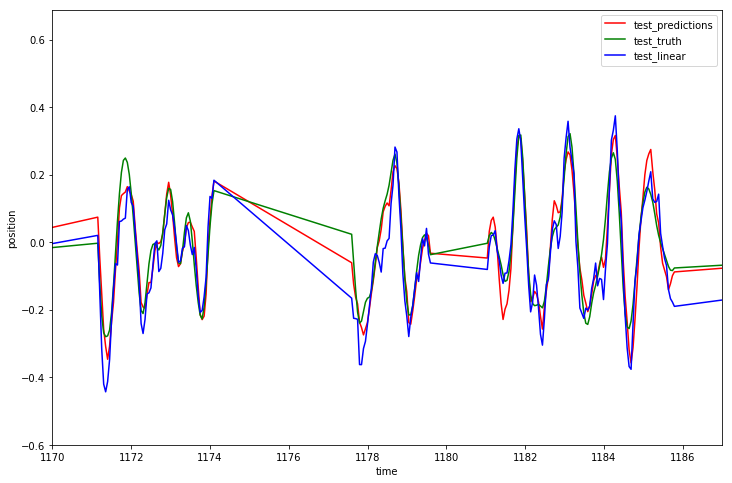

In [57]:
""" TODO
Plot the test set predictions for the best model compared with
the ground truth and the test set predictions from the linear model, 
for 1170 to 1187 seconds
"""
plt.figure(figsize=(12,8))
plt.plot(time_test, preds_.reshape(-1,1), 'r', label = 'test_predictions')
plt.plot(time_test, ytest.reshape(-1, 1), 'g', label = 'test_truth')
plt.plot(time_test, preds_lt, 'b', label = 'test_linear' )
plt.xlabel('time')
plt.ylabel('position')
plt.xlim([1170,1187])
plt.legend()



Text(0.5, 1.0, 'validation set')

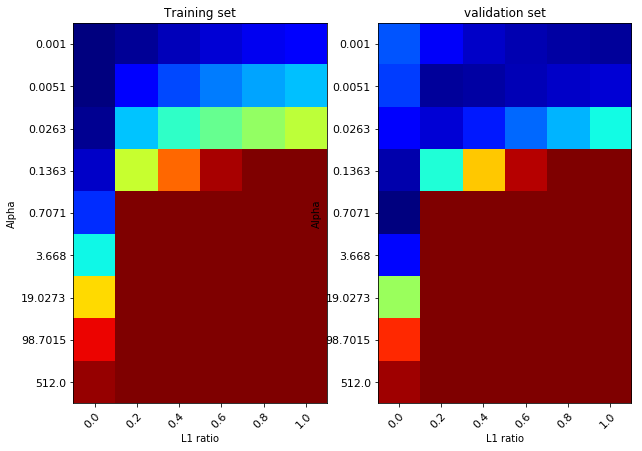

In [56]:
""" TODO
Plot the mean training and validation results from the grid search as a 
colormap, for the alpha (y-axis) vs the l1 ratio (x-axis). Use two subplots, 
subplot(1,2,1) for the training set performance and subplot(1,2,2) for the 
validation set performance. You can use imshow or matshow to display colormaps. 
Make sure to include appropriate labels, ticks, and colorbars. Use the imshow function
within matplotlib.pyplot.
"""
rmses_train = np.sqrt(-stats['mean_train_score'].reshape( len(alphas), len(l1_ratios)))
fig, ax = plt.subplots(1,2, figsize=(10,8))

ax[0].imshow(rmses_train, cmap = 'jet')
ax[0].set_xticks(np.arange(len(l1_ratios)))
ax[0].set_yticks(np.arange(len(alphas)))
ax[0].set_xticklabels(np.around(l1_ratios,4), fontsize = 11)
ax[0].set_yticklabels(np.around(alphas,4), fontsize = 11)
plt.setp(ax[0].get_xticklabels(), rotation= 45, ha ='right', rotation_mode = 'anchor')
ax[0].set_xlabel('L1 ratio')
ax[0].set_ylabel('Alpha')
ax[0].set_title('Training set')


rmses_test = np.sqrt(-stats['mean_test_score'].reshape( len(alphas), len(l1_ratios)))
ax[1].imshow(rmses_test, cmap = 'jet')
ax[1].set_xticks(np.arange(len(l1_ratios)))
ax[1].set_yticks(np.arange(len(alphas)))
ax[1].set_xticklabels(np.around(l1_ratios,4), fontsize = 11)
ax[1].set_yticklabels(np.around(alphas,4), fontsize = 11)
plt.setp(ax[1].get_xticklabels(), rotation= 45, ha ='right', rotation_mode = 'anchor')
ax[1].set_xlabel('L1 ratio')
ax[1].set_ylabel('Alpha')
ax[1].set_title('validation set')


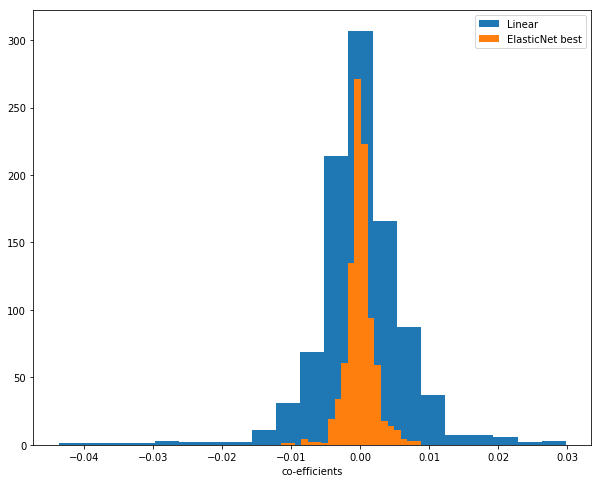

In [42]:
""" TODO
Generate a plot that contains two overlapping histograms:
- Coefficients discovered by LinearRegression
- Coefficients discovered by the best ElasticNet 
    (best is relative to the validation performnce)
"""
nbins = 21
plt.figure(figsize=(10,8))
plt.hist(lmodel.coef_, bins=nbins, label = "Linear")
plt.hist(best_estimator.coef_,bins=nbins, label="ElasticNet best")
plt.xlabel("co-efficients")
plt.legend()



